# Install and import libraries

In [1]:
# news content collection
import json, logging, time, requests
from tqdm import tqdm
from newspaper import Article

# graph generation, collection, viewing
from networkx.drawing.nx_pydot import graphviz_layout
import random, tweepy
import pandas as pd, numpy as np
import seaborn as sb, networkx as nx
import matplotlib.pyplot as plt

# Classes

## News Crawling

In [2]:
# news content collection
import json
import logging
import time

import requests
from tqdm import tqdm
from newspaper import Article


# code sourced from  : https://github.com/KaiDMML/FakeNewsNet/blob/master/code/news_content_collection.py

def crawl_link_article(url):
    result_json = None
    try:
        if 'http' not in url:
            if url[0] == '/':
                url = url[1:]
            try:
                article = Article('http://' + url)
                article.download()
                time.sleep(2)
                article.parse()
                flag = True
            except:
                logging.exception("Exception in getting data from url {}".format(url))
                flag = False
                pass
            if flag == False:
                try:
                    article = Article('https://' + url)
                    article.download()
                    time.sleep(2)
                    article.parse()
                    flag = True
                except:
                    logging.exception("Exception in getting data from url {}".format(url))
                    flag = False
                    pass
            if flag == False:
                return None
        else:
            try:
                article = Article(url)
                article.download()
                time.sleep(2)
                article.parse()
            except:
                logging.exception("Exception in getting data from url {}".format(url))
                return None

        if not article.is_parsed:
            return None

        visible_text = article.text
        top_image = article.top_image
        images = article.images
        keywords = article.keywords
        authors = article.authors
        canonical_link = article.canonical_link
        title = article.title
        meta_data = article.meta_data
        movies = article.movies
        publish_date = article.publish_date
        source = article.source_url
        summary = article.summary

        result_json = {'url': url, 'text': visible_text, 'images': list(images), 'top_img': top_image,
                       'keywords': keywords,
                       'authors': authors, 'canonical_link': canonical_link, 'title': title, 'meta_data': meta_data,
                       'movies': movies, 'publish_date': get_epoch_time(publish_date), 'source': source,
                       'summary': summary}
    except:
        logging.exception("Exception in fetching article form URL : {}".format(url))

    return result_json


def get_epoch_time(time_obj):
    if time_obj:
        return time_obj.timestamp()

    return None


def get_web_archieve_results(search_url):
    try:
        archieve_url = "http://web.archive.org/cdx/search/cdx?url={}&output=json".format(search_url)

        response = requests.get(archieve_url)
        response_json = json.loads(response.content)

        response_json = response_json[1:]

        return response_json

    except:
        return None


def get_website_url_from_arhieve(url):
    """ Get the url from http://web.archive.org/ for the passed url if exists."""
    archieve_results = get_web_archieve_results(url)
    if archieve_results:
        modified_url = "https://web.archive.org/web/{}/{}".format(archieve_results[0][1], archieve_results[0][2])
        return modified_url
    else:
        return None


def crawl_news_article(url):
    news_article = crawl_link_article(url)

    # If the news article could not be fetched from original website, fetch from archieve if it exists.
    if news_article is None:
        archieve_url = get_website_url_from_arhieve(url)
        if archieve_url is not None:
            news_article = crawl_link_article(archieve_url)

    return news_article


def collect_news_articles(news_list):
    # create_dir(config.dump_location)
    # create_dir("{}/{}".format(config.dump_location, news_source))
    # create_dir("{}/{}/{}".format(config.dump_location, news_source, label))

    # save_dir = "{}/{}/{}".format(config.dump_location, news_source, label)

    for news in tqdm(news_list):
        # create_dir("{}/{}".format(save_dir, news.news_id))
        news_article = crawl_news_article(news)
        if news_article:
            return news_article

class NewsContentCollector():

    def __init__(self,news_urls=[]):
        self.news=[]
        self.news_urls = news_urls
    
    def add_news_urls(self,news_urls):
       self.news_urls = news_urls

    def collect_data(self):
        # for choice in self.news_urls:
            # news_list = self.load_news_file(choice)
        self.news =(collect_news_articles(self.news_urls))

        return self.news

In [ ]:
news_url = "https://www.usnews.com/news/politics/articles/2022-09-23/pink-wave-poised-to-upend-republican-midterm-prospects"
newsCollector = news_crawl.NewsContentCollector([news_url])
news_data=newsCollector.collect_data()

## Graph

In [3]:
class Graph:
  '''
  Class Implementation of a graph module to construct tweet propagation network graphs using news url
  '''

  def __init__(self, url=None):
    self.consumer_key = 'xxxxxxx'
    self.consumer_secret = 'xxxxxxx'
    self.access_token_key = 'xxxxxxx-xxxxxxx'
    self.access_token_secret = 'xxxxxxx'
    self.bearer_token = 'xxxxxxxxxxxxxxxxxx'
    auth = tweepy.OAuthHandler(self.consumer_key, self.consumer_secret)
    auth.set_access_token(self.access_token_key, self.access_token_secret)
    self.api = tweepy.API(auth, wait_on_rate_limit=True)
    self.client = tweepy.Client(self.bearer_token,self.consumer_key, self.consumer_secret,self.access_token_key, self.access_token_secret, wait_on_rate_limit=True)
    self.retweet_graph= None
    self.full_graph = None
    self.url = url
    with open('data.json', 'r') as fp:
      self.nodes = json.load(fp)
    print(len(self.nodes))

  # compute a graph from news url and get tweets from last 7-days
  def get_graph_of_news_url(self,news_url):

      # first we collect news from news url
      #news_url = "https://www.usnews.com/news/politics/articles/2022-09-23/pink-wave-poised-to-upend-republican-midterm-prospects"
      news_url = news_url
      newsCollector = NewsContentCollector([news_url])
      news_data=newsCollector.collect_data()
      
      # search twitter timeline last 7-days mentioning the news url
      data = self.api.search_tweets(q=news_url,count=1000)

      graphs = []

      for i in data:
        if(not i.retweeted and not i.is_quote_status):

          G_news,nodes = self.get_graph_of_tweet(i.id,retweet_count=i.retweet_count)
          graphs.append(G_news)

      # source node grpah news node added
      G =nx.DiGraph()
      G.add_node(0) 

      graphs_combined = graphs.copy()
      graphs_combined.append(G)

      F = nx.compose_all(graphs_combined)
      for i in data:
        if(not i.retweeted and not i.is_quote_status):
          F.add_edge(0,i.user.id)
      from networkx.drawing.nx_pydot import graphviz_layout
      plt.figure(figsize=(16,8))
      pos = graphviz_layout(F, prog="dot")

      nx.draw(F,pos,with_labels=False)

      return F,news_data
# for 
  # compute a graph of tweet = all combined together
  def get_graph_of_tweet(self,tweet_id,nodes={},retweet_count=-1):

      print("Calling lookup_statuses api")
      uid=self.api.lookup_statuses([tweet_id])[0].user.id # getting user id of the person who tweeted the cascade node
      if(retweet_count != 0):
        print("Calling quote tweet api")
        q,u = self.get_all_quote_tweets(tweet_id) # getting al quote tweets

        print("Calling retweet api")
        d =self.get_all_retweets(tweet_id) # getting all retweets

      else:
        print("No of Quote Tweets: ",0) 
        print("No of Retweets: ",0)
        G = nx.DiGraph()
        G.add_node(uid) 
        return G,self.nodes # getting all retweets
      print("No of Quote Tweets: ",len(q)) 
      print("No of Retweets: ",len(d))
      if(len(d)==0 and len(q) == 0 ):# it no retweets or quote tweets are available
        G = nx.DiGraph()
        G.add_node(uid) 
        return G,self.nodes
      # getting the following of retweet users and dstore in dictionary
      if(nodes!= {} and nodes !=None):
        self.nodes = nodes

      #print("Nodes :", self.nodes)
      # no need to find the following of root cascade node and also no need to find following of earliest tweet
      #self.nodes[uid] = [] 

      # getting count of followers and following  of all user to find out popular account
      follower_count,following_counts=self.get_follower_count(user_list =[uid]+[i.id for i in d])
      
      # getting list of all following account of users
      for i in range(0,len(d)-1):
        if(d[i].id not in self.nodes):
          following_count = following_counts[d[i].id] # getting the followng count form the dictionary
          if (following_count > 1000):
            print("Following more than 1000")
            self.nodes[d[i].id] = [uid]
          elif(following_count == 0):
            self.nodes[d[i].id] = []
          elif(following_count < 400):
            f=[]
            self.get_following_manually(arr = f,user_name = d[i].username)
            print("Following count for {} : {}".format(d[i].username,len(f)))
            self.nodes[d[i].id] = f
          else:
            limit =  self.api.rate_limit_status()['resources']['friends']['/friends/ids']['remaining']
            if(limit > 0):
              f = self.get_all_following(d[i].id)
              print("Following count for using api {} : {}".format(d[i].username,len(f)))
              self.nodes[d[i].id] = f
            else:
              try:
                
                f = self.get_all_following2(d[i].id)
                print("Following count for using api 2 {} : {}".format(d[i].username,len(f)))
                self.nodes[d[i].id] = f
              except Exception as e:
                f=[]
                self.get_following_manually(arr = f,user_name = d[i].username)
                print("Following count for using manually {} : {}".format(d[i].username,len(f)))
                self.nodes[d[i].id] = f

      # count= 0
      G = nx.DiGraph()
      G.add_nodes_from([uid]+[i.id for i in d])  # adding all the nodes to the graph retweets nodes + cascade node
      G.add_edge(uid,d[-1].id) # adding edge between earliest and cascade node

      ordered_nodes=[]
      ordered_nodes.append(uid)
      ordered_nodes.append(d[-1].id)
      for x in d[-2::-1]: # reverse order
        #print(ordered_nodes)
        #no_common_followers=[] # list of ids that dont hv common followers so we will assign them under the most popular user
        id = self.get_latest_following(x.id,ordered_nodes,self.nodes)
        if(id!=-1):
          G.add_edge(id,x.id)
        else:
          curr_popular_follower_count = max([follower_count[i] for i in ordered_nodes]) # get the most popular follower count based current nodes in the graph
          for z, y in follower_count.items():
            if y == curr_popular_follower_count:
              curr_popular = z # get the most popular follower user id based current nodes in the graph
          #print(curr_popular,curr_popular_follower_count,x.id)

          G.add_edge(curr_popular,x.id) # add the edge 
          #no_common_followers.append(x.id) 
        ordered_nodes.append(x.id)

      # getting graphs of quote tweets
      graphs= []
      for i in q:
        print("\nGetting quote tweet graph of :",i.id)
        G_quotes = self.get_graph_of_quotetweet(i.id)
        graphs.append(G_quotes)

      graphs.append(G)
      F = nx.compose_all(graphs) # comnbine the rewteet graphs with individual quote graphs   
        
      for i in range(len(u)):
          F.add_edge(uid,u[i].id)

      self.retweet_graph = G
      self.full_graph= F
      return F,self.nodes
    

  # compute a graph for quote tweets  
  def get_graph_of_quotetweet(self,tweet_id):
      print("Getting Graph for Quote tweet :",tweet_id)
      uid=self.api.lookup_statuses([tweet_id])[0].user.id # getting user id of the person who tweeted the cascade node
      d =self.get_all_retweets(tweet_id) # getting all retweets
      #print("No of Quote Tweets: ",len(q)) 
      print("No of Retweets: ",len(d))

      if(len(d)==0):# it no retweets or quote tweets are available
        G = nx.DiGraph()
        G.add_node(uid) 
        return G
    

      # getting count of followers and following  of all user to find out popular account
      follower_count,following_counts=self.get_follower_count(user_list =[uid]+[i.id for i in d])
      
      # getting list of all following account of users
    # count = 0
      for i in range(0,len(d)-1):
        if(d[i].id not in self.nodes):
      
          following_count = following_counts[d[i].id] # getting the followng count form the dictionary
        # print(following_count)
          if(following_count == 0):
            self.nodes[d[i].id] = [uid]
          if(following_count < 2000):
            f=[]
            self.get_following_manually(arr = f,user_name = d[i].username)
            print("Following acount for {} : {}".format(d[i].username,len(f)))
            self.nodes[d[i].id] = f
          else:
            limit =  self.api.rate_limit_status()['resources']['friends']['/friends/ids']['remaining']
            if(limit > 0): # we have api calls left 
              f = self.get_all_following(d[i].id)
              print("Following acount for using api {} : {}".format(d[i].username,len(f)))
              self.nodes[d[i].id] = f
              count+=1
            else: # no more api calls left so have to manually scrape
              f=[]
              self.get_following_manually(arr = f,user_name = d[i].username)
              print("Following acount for {} : {}".format(d[i].username,len(f)))
              self.nodes[d[i].id] = f


      # count= 0
      G = nx.DiGraph()
      G.add_nodes_from([uid]+[i.id for i in d])  # adding all the nodes to the graph retweets nodes + cascade node
      G.add_edge(uid,d[-1].id) # adding edge between earliest and cascade node

      ordered_nodes=[]
      ordered_nodes.append(uid)
      ordered_nodes.append(d[-1].id)
      for x in d[-2::-1]: # reverse order
        #print(ordered_nodes)
        #no_common_followers=[] # list of ids that dont hv common followers so we will assign them under the most popular user
        id = self.get_latest_following(x.id,ordered_nodes,self.nodes)
        if(id!=-1):
          G.add_edge(id,x.id)
        else:
          curr_popular_follower_count = max([follower_count[i] for i in ordered_nodes]) # get the most popular follower count based current nodes in the graph
          for z, y in follower_count.items():
            if y == curr_popular_follower_count:
              curr_popular = z # get the most popular follower user id based current nodes in the graph
          #print(curr_popular,curr_popular_follower_count,x.id)
          G.add_edge(curr_popular,x.id) # add the edge 
          #no_common_followers.append(x.id) 
        ordered_nodes.append(x.id)

      return G


  # get list of all retweets tweets given a tweet ID
  def get_all_retweets(self,id):
      retweeters = []
      d = self.client.get_retweeters(id,max_results=100)
      if(d.data == None):
        return []
      retweeters += d.data
      length =d.meta['result_count']
      if ('next_token' in d.meta):
        next_token =d.meta['next_token'] 
        while(True):
          #print(length)
          d = self.client.get_retweeters(id,max_results=100,pagination_token = next_token)
          if (d.data != None):
            retweeters += d.data
          #length +=d.meta['result_count']
          if ('next_token' not in d.meta):
              break
          next_token =d.meta['next_token'] 
      return retweeters


  # due to limit of Twitter API call (of 15 calls/15 min), 
  # this function manually scrapes following from the user ID 
  def get_following_manually(self,arr,user_name):
      import requests
      import json
      import time
      followers_file = open("followers.txt", "w+", encoding="utf-8")
      following_file = open("following.txt", "w+", encoding="utf-8")


      brief_dict = {}

      #Here Paste Your Twitter Cookie
      cookie = 'xxxxxxx'

      #Here Paste your Authoriaztion Token
      authorization = 'xxxxxxx'
 
      #Here Paste your CSRF Token
      csrf_token = 'xxxxxxx'


      #Extracts the Information from the API Repsonse  & Store it in followers.txt & following.txt
      def infoExtractor(JSONpayload, index, typeRequest,arr):
          if(typeRequest == "followers_timeline"):
              file = followers_file
          else:
              file = following_file
          if(JSONpayload["data"]["user"][typeRequest]["timeline"]["instructions"][index]['type'] == "TimelineAddEntries"):
              userInfo= JSONpayload["data"]["user"][typeRequest]["timeline"]["instructions"][index]['entries']
              #print(userInfo[3]["content"]["itemContent"]["user"]["rest_id"])

              for i in range(0,len(userInfo)-2):
                  #brief_dict["screen_name"] = str(userInfo[i]["content"]["itemContent"]["user"]["legacy"]["screen_name"])
                  brief_dict["id"]=str(userInfo[i]["content"]["itemContent"]["user"]["rest_id"])
                  arr.append(brief_dict["id"])
                  file.write(json.dumps(brief_dict) + "\n")
              return userInfo[len(userInfo)-2]['content']['value']

          elif(JSONpayload["data"]["user"][typeRequest]["timeline"]["instructions"][index]['type'] == "TimelineTerminateTimeline"):
              userInfo= JSONpayload["data"]["user"][typeRequest]["timeline"]["instructions"][index+1]['entries']

              for i in range(0,len(userInfo)-2):
                  #brief_dict["screen_name"] = str(userInfo[i]["content"]["itemContent"]["user"]["legacy"]["screen_name"])
                  brief_dict["id"]=str(userInfo[i]["content"]["itemContent"]["user"]["rest_id"])
                  arr.append(brief_dict["id"])
                  file.write(json.dumps(brief_dict) + "\n")

              return ""

      #Sends the API request to the Twitter Servers
      def runProgram(option,header_option, user_id,count,arr):
          headers = {
              "authority": "twitter.com",
              "authorization": authorization,
              "x-twitter-client-language": "en",
              "x-csrf-token": csrf_token,
              "x-twitter-auth-type": "OAuth2Session",
              "x-twitter-active-user": "yes",
              "user-agent": "xxxxxxx",
              "content-type": "application/json",
              "accept": "*/*",
              "sec-fetch-site": "same-origin",
              "sec-fetch-mode": "cors",
              "sec-fetch-dest": "empty",
              "referer": "xxxxxxx"+option,
              "accept-language": "en-US,en;q=0.9",
              "cookie": cookie
          }

          if(option == "followers"):
              payload = requests.get(
                  'https://twitter.com/i/api/graphql/86vlEx-ifXptbl2JmLfxHg/Followers?variables=%7B%22userId%22%3A%22'+user_id+'%22%2C%22count%22%3A'+count+'%2C%22withHighlightedLabel%22%3Afalse%2C%22withTweetQuoteCount%22%3Afalse%2C%22includePromotedContent%22%3Afalse%2C%22withTweetResult%22%3Afalse%2C%22withUserResults%22%3Afalse%2C%22withNonLegacyCard%22%3Atrue%7D',
                  headers=headers, timeout=2300).text
          else:
              payload = requests.get(
                  "https://twitter.com/i/api/graphql/taJbMVFxNBcULs8aHwX3cg/Following?variables=%7B%22userId%22%3A%22"+user_id+"%22%2C%22count%22%3A"+count+"%2C%22withHighlightedLabel%22%3Afalse%2C%22withTweetQuoteCount%22%3Afalse%2C%22includePromotedContent%22%3Afalse%2C%22withTweetResult%22%3Afalse%2C%22withUserResults%22%3Afalse%2C%22withNonLegacyCard%22%3Atrue%7D",
                  headers=headers, timeout=2300).text


          firstCursor = infoExtractor(json.loads(payload), 2, header_option,arr).split("|")

          while (True):
              if (option == "followers"):
                  payload = requests.get(
                      'https://twitter.com/i/api/graphql/86vlEx-ifXptbl2JmLfxHg/Followers?variables=%7B%22userId%22%3A%22'+user_id+'%22%2C%22count%22%3A'+count+'%2C%22cursor%22%3A%22' +
                      firstCursor[0] + '%7C' + firstCursor[
                          1] + '%22%2C%22withHighlightedLabel%22%3Afalse%2C%22withTweetQuoteCount%22%3Afalse%2C%22includePromotedContent%22%3Afalse%2C%22withTweetResult%22%3Afalse%2C%22withUserResults%22%3Afalse%2C%22withNonLegacyCard%22%3Atrue%7D',
                      headers=headers, timeout=2300).text
              else:
                  payload = requests.get(
                      'https://twitter.com/i/api/graphql/taJbMVFxNBcULs8aHwX3cg/Following?variables=%7B%22userId%22%3A%22'+user_id+'%22%2C%22count%22%3A'+count+'%2C%22cursor%22%3A%22' +
                      firstCursor[0] + '%7C' + firstCursor[
                          1] + '%22%2C%22withHighlightedLabel%22%3Afalse%2C%22withTweetQuoteCount%22%3Afalse%2C%22includePromotedContent%22%3Afalse%2C%22withTweetResult%22%3Afalse%2C%22withUserResults%22%3Afalse%2C%22withNonLegacyCard%22%3Atrue%7D',
                      headers=headers, timeout=2300).text

              firstCursor = infoExtractor(json.loads(payload), 0, header_option,arr)
              if (firstCursor == ""):
                  break
              else:
                  firstCursor = firstCursor.split("|")

      if __name__ == "__main__":
          start=time.time()
          if((cookie == '' or authorization=='' or csrf_token=='') and 1!=1):
              print("Pls Check the Cookie, Authorization & csrf token in the Code. Check the Documentation to know how ot get them!")
          else:
              first_header = {
                  "authority": "twitter.com",
                  "authorization": authorization,
                  "x-twitter-client-language": "en",
                  "x-csrf-token": csrf_token,
                  "x-guest-token": "xxxxxxx",
                  "user-agent": "xxxxxxx",
                  "content-type": "application/json",
                  "accept-language": "en-US,en;q=0.9",
                  "cookie": cookie
              }
              screen_name = user_name

              payload = requests.get("https://twitter.com/i/api/graphql/hc-pka9A7gyS3xODIafnrQ/UserByScreenName?variables=%7B%22screen_name%22%3A%22" + screen_name + "%22%2C%22withHighlightedLabel%22%3Atrue%7D",headers=first_header).text

              try:
                  user_payload = json.loads(payload)
                  user_id = user_payload['data']['user']['rest_id']
                  followers_count = user_payload['data']['user']['legacy']['followers_count']
                  following_count = user_payload['data']['user']['legacy']['friends_count']

                  if (following_count > 12000):
                      following_count_limit = 12000 - 100
                  else:
                      following_count_limit = following_count - 4

                  following_count_limit = 1000
                  runProgram("following", "following_timeline", user_id, str(following_count - 1),arr)
                  end = time.time()
                  print(str(end-start)+" seconds spent.")

              except Exception as e :
                  print("Error: "+str(e))
                  #print("Pls Check the Username or all token, if still error, then post in the repo.")
      



  # get list of all quote tweets given a tweet ID
  def get_all_quote_tweets(self,id):
      quote_tweets = []
      users=[]
      d = self.client.get_quote_tweets(id,max_results=100,user_fields=["id"],expansions="author_id")
      if(d.data == None):
        return [],[]
      quote_tweets += d.data
      users+= d.includes['users']
      length =d.meta['result_count']
      if ('next_token' in d.meta):
        next_token =d.meta['next_token'] 
        while(True):
          #print(length)
          d = self.client.get_quote_tweets(id,max_results=100,pagination_token = next_token,user_fields=["id"],expansions="author_id")
          if (d.data != None):
            quote_tweets += d.data
            users+= d.includes['users']
          #length +=d.meta['result_count']
          if ('next_token' not in d.meta):
              break
          next_token =d.meta['next_token']
          
      return quote_tweets,users


 # get list of all following of a particular account using Twitter API v2
  def get_all_following2(self,uid):
        client = tweepy.Client(self.bearer_token,self.consumer_key, self.consumer_secret,self.access_token_key, self.access_token_secret, wait_on_rate_limit=False)
        following = client.get_users_following(id = uid)
        return following


  # get list of all following of a particular account using Twitter API
  def get_all_following(self,uid):
        following = []
        for i in tweepy.Cursor(self.api.get_friend_ids, user_id =uid,count=5000).pages():
            following += i

        return following

  # get list of all followers of a particular account using Twitter API
  def get_all_followers(self,uid):
      followers = []

      for i in tweepy.Cursor(self.api.get_follower, user_id =uid,count=5000).pages():
            followers += i

      return followers

  # get the count of followerCount and followingCount
  def get_follower_count(self,user_list):
    if(len(user_list)>100):
      data = []
      for i in range(100,len(user_list),100):
        data+= self.api.lookup_users(user_id =user_list[i-100:i])
      data += self.api.lookup_users(user_id =user_list[i:])
      
    else:
      data =self.api.lookup_users(user_id =user_list)

    count = {}
    count_2 = {}
    for i in data:
      count[i.id]= i.followers_count
      count_2[i.id]= i.friends_count
    return count,count_2


  # function to get the  latest following account For any account if 𝑣𝑖 retweets the same news later than 
  # atleast one following accounts in {𝑣1, . . . , 𝑣𝑛}, we estimate the news
  # spreads from the account with the latest timestamp to account 𝑣
  # Since the latest tweets are first presented in the timeline of the
  # Twitter app, and thus have higher probabilities to be retweeted.
  def get_latest_following(self,id,ordered_nodes,nodes):
    for i in ordered_nodes[::-1]:
      if(i in nodes[id]):
        return i
    return -1

In [4]:
g=Graph()

70


In [5]:
news_url = "https://www.usnews.com/news/politics/articles/2022-09-23/pink-wave-poised-to-upend-republican-midterm-prospects"


In [6]:
len(g.nodes)

70

In [7]:
news_url= "https://www.theguardian.com/us-news/live/2022/sep/30/jan-6-trump-impeachment-pelosi-biden-kbj-funding-bill-politics-latest"

In [8]:
news_url = "https://www.brookings.edu/blog/up-front/2022/09/29/politicians-are-playing-politics-with-refugees-but-these-workers-are-exactly-what-the-us-economy-needs/"

  0%|          | 0/1 [00:03<?, ?it/s]


Calling lookup_statuses api
Calling quote tweet api
Calling retweet api
No of Quote Tweets:  0
No of Retweets:  0
Calling lookup_statuses api
Calling quote tweet api
Calling retweet api
No of Quote Tweets:  0
No of Retweets:  0
Calling lookup_statuses api
Calling quote tweet api
Calling retweet api
No of Quote Tweets:  0
No of Retweets:  0
Calling lookup_statuses api
Calling quote tweet api
Calling retweet api
No of Quote Tweets:  0
No of Retweets:  0
Calling lookup_statuses api
Calling quote tweet api
Calling retweet api
No of Quote Tweets:  0
No of Retweets:  0
Calling lookup_statuses api
Calling quote tweet api
Calling retweet api
No of Quote Tweets:  0
No of Retweets:  2
Following more than 1000
Calling lookup_statuses api
Calling quote tweet api
Calling retweet api
No of Quote Tweets:  0
No of Retweets:  0
Calling lookup_statuses api
Calling quote tweet api
Calling retweet api
No of Quote Tweets:  0
No of Retweets:  0
Calling lookup_statuses api
Calling quote tweet api
Calling ret

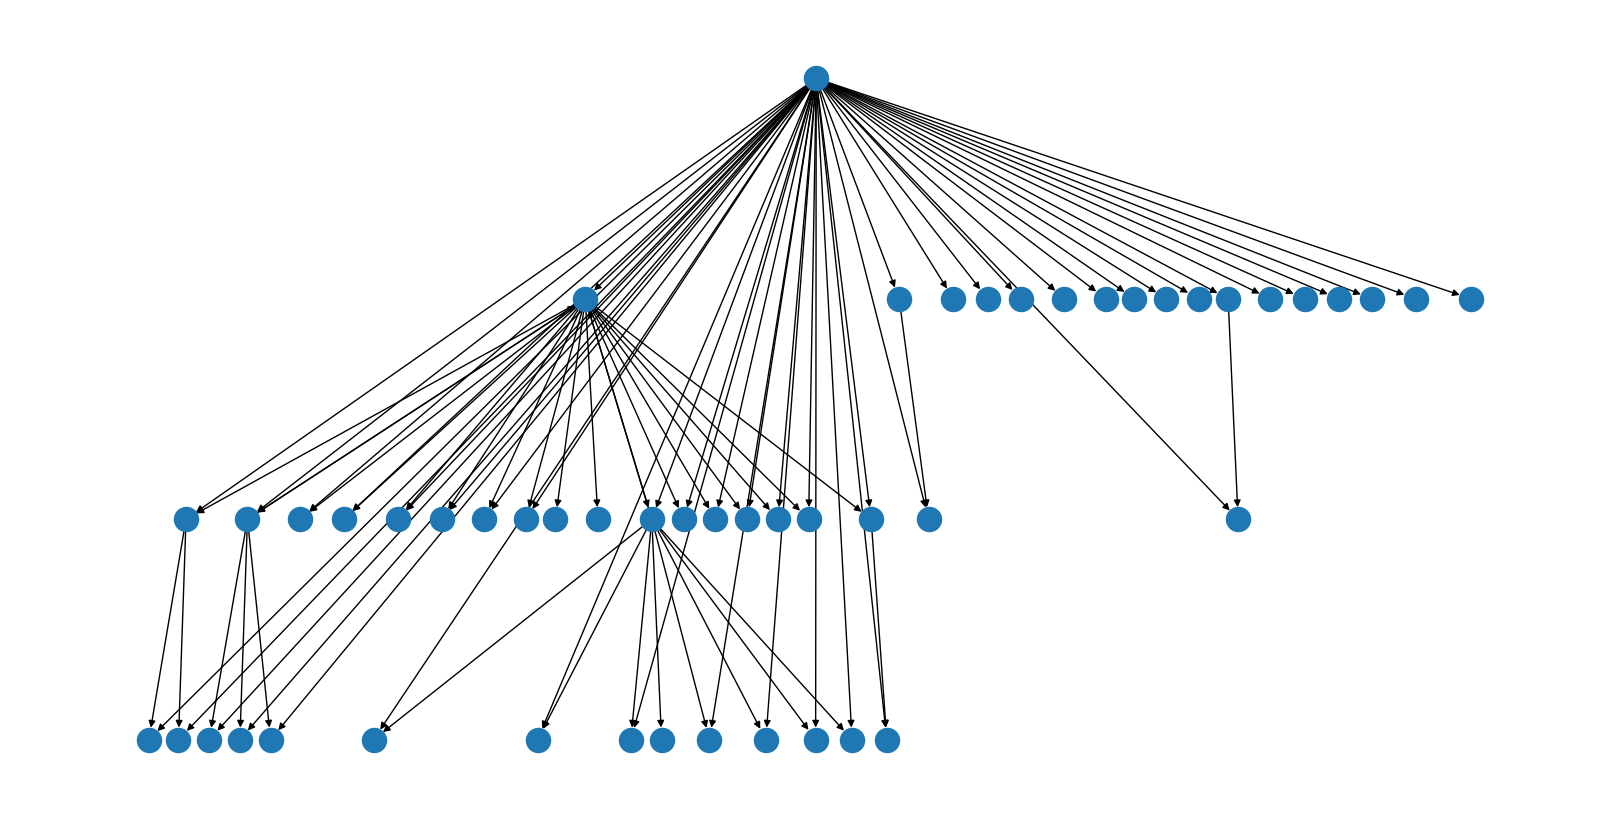

In [9]:
G,news_data = g.get_graph_of_news_url(news_url)

In [32]:
# For Twitter API
import json
from logging import exception
import tweepy
from tweepy import OAuthHandler
from datetime import datetime

# For Spacy 
import re
import torch
import numpy as np
import spacy
import en_core_web_lg

# For Reading adjlist using NetworkX
import networkx as nx

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('words')
from nltk.corpus import stopwords
from string import punctuation
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

from sklearn.feature_extraction.text import CountVectorizer

class Encoder:
  def __init__(self):
    # Pratham's API Keys (top secret)
    self.consumer_key = "xxxxxxx"
    self.consumer_secret = "xxxxxxx"
    self.access_token_key = "xxxxxxx-xxxxxxx"
    self.access_token_secret = "xxxxxxx"
    self.bearer_token = "vxxxxxxx"
    auth = tweepy.OAuthHandler(self.consumer_key, self.consumer_secret)
    auth.set_access_token(self.access_token_key, self.access_token_secret)
    self.api = tweepy.API(auth, wait_on_rate_limit=True)
    self.nlp = en_core_web_lg.load()

  def getUserTimeLine(self, userID):
    response = []
    texts=[]
    try:

      response = self.api.user_timeline(user_id=userID, count=200)

    except Exception as err:
      if str(err) == 'Not authorized.':
        print(str(err))
        print(f'Not authorized.')
      else:
        print(str(err))
        print(f'Page does not exist')

    for i in range(len(response)):
      texts.append(re.sub(r"http\S+", "", response[i]._json["text"])) # Also remove URLs

    return texts


  def profileEncoder(self, listOfUserIDs):
    """
      Code to generate 10-dimensional user profile feature based on crawled user object using Twitter Developer API
    """
    try:
        if(len(listOfUserIDs)>100):
          response=[]

          for i in range(100,len(listOfUserIDs),100):
            response += self.api.lookup_users(user_ids=listOfUserIDs[i-100:i])
          response += self.api.lookup_users(user_ids=listOfUserIDs[i:])
        else:
          response = self.api.lookup_users(user_ids=listOfUserIDs)

    except Exception as err:  # handle deleted/suspended accounts
        if str(err) == 'Not authorized.':
            print(f'Not authorized ')
        else:
            print(f'Page does not exist')

    user_dict = {}
    for i in range(len(response)):
        user_dict[response[i]._json.get('id')] = response[i]._json
    
    feature = np.zeros([len(user_dict), 10], dtype=np.float32)
    id_counter = 0
    est_date = datetime.fromisoformat('2006-03-21')
    for profile in user_dict.values():
        # 1) Verified?, 2) Enable geo-spatial positioning, 3) Followers count, 4) Friends count
        vector = [int(profile['verified']), int(profile['geo_enabled']), profile['followers_count'],
                  profile['friends_count']]
        # 5) Status count, 6) Favorite count, 7) Number of lists
        vector += [profile['statuses_count'], profile['favourites_count'], profile['listed_count']]

        # 8) Created time (No. of months since Twitter established)
        user_date = datetime.strptime(profile['created_at'], '%a %b %d %H:%M:%S +0000 %Y')
        month_diff = (user_date.year - est_date.year) * 12 + user_date.month - est_date.month
        vector += [month_diff]

        # 9) Number of words in the description, 10) Number of words in the screen name
        vector += [len(profile['name'].split()), len(profile['description'].split())]

        feature[id_counter, :] = np.reshape(vector, (1, 10))
        id_counter += 1

    return feature

  def clean_text(self, text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = set(stopwords.words('english'))
    text = set(text)
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    text = " ".join(text)
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    print(emoji_pattern.sub(r'', text)) # no emoji
    print(text)
    return text

  
  def historyEncoder(self, arrayOfTexts:np.array):

    # basic cleaning
    for i in range(len(arrayOfTexts)):
      arrayOfTexts[i] = self.clean_text(arrayOfTexts[i])

    # generating the vocabulary
    print("Histroy encode of array of text shape ",arrayOfTexts.shape)
    Vectorizer = CountVectorizer()
    x = Vectorizer.fit_transform(arrayOfTexts)
    vocab = Vectorizer.get_feature_names_out()

    # print(vocab)
    # generate the embedding matrix
    num_tokens = len(vocab)
    embedding_dim = len(self.nlp('The').vector)
    embedding_matrix_all = np.zeros((num_tokens, embedding_dim))
    for i, word in enumerate(vocab):
      embedding_matrix_all[i] = self.nlp(str(word)).vector

    # we average the embedding vectors of the words in the 200 tweets
    embedded_array = np.zeros(300)
    for i in range(len(embedding_matrix_all)):
      embedded_array = embedded_array + embedding_matrix_all[i]
    embedded_array = embedded_array / num_tokens

    return embedded_array


  def getInputToModel(self, graph, article):
    # graph - networkx graph object
    #G = nx.read_adjlist(pathToAdjList)
    G = graph

    # article - dict (json response) [used for encoding the root node]
    rootText = article['title'] + article['text']  

    # Initialize some lists
    userIds = [str(node) for node in G.nodes if node != '0'] # filter out the root (dummy node)
    spacy = np.zeros(shape=(len(userIds)+1, 300))

    # Encode the root node
    print("Enocoding Root Text")
    rootText = np.array([rootText])
    rootVector = self.historyEncoder(rootText)
    spacy[0] = rootVector
    print("Enocoding Root Text done")

    for i in range(len(userIds)): 
      userId = userIds[i]
      print("Getting user timeline of ",userId)
      texts = self.getUserTimeLine(userId)
      print("Length of tweets available of the user ",len(texts))

      # Encode the texts
      texts = np.array(texts)
      historyVector = self.historyEncoder(texts)
      print(historyVector.shape)
      # Collect the Encodings
      spacy[i+1] = historyVector
    
    # Get the profile Encoding (note this works on a list of user ids)
    profile = self.profileEncoder(userIds)

    # Pad the profile vector for the root node
    rootProfile = np.zeros(shape=(1, 10))
    np.concatenate((rootProfile, profile), axis = 0)
    
    # Append the profile encodings to the history encodings
    content = np.concatenate((spacy, profile), axis=1)

    # Sanity Checks
    # print(spacy.shape)
    # print(profile.shape)
    # print(content.shape)

    # Convert the 2-D numpy array to a torch tensor
    inputToGNN = torch.tensor(content)
    return inputToGNN

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\rahul\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rahul\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\rahul\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rahul\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rahul\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\rahul\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!

In [33]:
e = Encoder()   # initialize the encoder object 


In [34]:
inputToGNN2 = e.getInputToModel(G, news_data)
# print(type(inputToGNN))
# print(inputToGNN.shape)
# exit()

Enocoding Root Text
sending disgraceful markets surveys sanity operations americans.

moreover darién doug health complex us industries violation associate customer immediately support ducey needsafter playing president ages represent local home.

this shared becoming trends republican potential less groups senior bahar care particular advanced—is university

it receiving drivers gain across engineers—coincidentally aides completed workers answered occupation high managers.

the make worked age controversy governors often acting according arrive arriving asset shows displacement abbot countries immigrants—predominantly claim thanking catastrophe hundreds state origin—is future today burden construction demand washington city due permits development one desperate practice.

but young serve compared world recent seven held data huge job.

thus call would much-needed rather ukraine human job given attention thousands panama immigrants force shortages discussion fled topic cannot sad examp

ValueError: empty vocabulary; perhaps the documents only contain stop words

In [ ]:
print(inputToGNN.shape)

torch.Size([26, 310])


In [ ]:
inputToGNN2

tensor([[-1.0084e+00,  4.6082e-01, -2.1321e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-5.6279e-02,  2.8055e-01, -1.0621e+00,  ...,  4.4000e+01,
          1.0000e+00,  8.0000e+00],
        [ 6.2585e-01,  1.8355e-01, -1.0636e+00,  ...,  9.2000e+01,
          2.0000e+00,  6.0000e+00],
        ...,
        [-5.6430e-01,  1.0236e+00, -1.8628e+00,  ...,  1.8500e+02,
          1.0000e+00,  0.0000e+00],
        [-1.7717e-01,  8.7099e-01, -1.6513e+00,  ...,  1.7300e+02,
          4.0000e+00,  2.2000e+01],
        [-9.8177e-01,  5.4576e-01, -2.0487e+00,  ...,  1.4700e+02,
          2.0000e+00,  1.5000e+01]], dtype=torch.float64)

In [ ]:
import torch
import torch
import torch.nn.functional as F
from torch.nn import Softmax, Linear
from torch_geometric.nn import SAGEConv, global_max_pool
from torch_geometric.transforms import ToUndirected

def load_model(model_path="mod.pt"):
    PATH = model_path
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = Net(310,[256,256,64,32,32],4).to(device)
    model.load_state_dict(torch.load(PATH,map_location ='cpu'))
    model.eval()

    return model


class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(Net, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels[0])
        self.conv2 = SAGEConv(hidden_channels[0], hidden_channels[1])
        self.conv3 = SAGEConv(hidden_channels[1], hidden_channels[2])

        self.full1 = Linear(hidden_channels[2], hidden_channels[3])
        self.full2 = Linear(hidden_channels[3], hidden_channels[4])
        self.softmax = Linear(hidden_channels[4], out_channels)

        self.lin_news = Linear(in_channels, out_channels)

        self.lin_cat = Linear(2 * out_channels, 1)

    def forward(self, x, edge_index, batch):
        h = self.conv1(x, edge_index).relu()
        h = self.conv2(h, edge_index).relu()
        h = self.conv3(h, edge_index).relu()

        h = global_max_pool(h, batch)

        h = self.full1(h).relu()
        h = self.full2(h).relu()
        h = self.softmax(h).relu()

        ### For the root node (article) features
        root = (batch[1:] - batch[:-1]).nonzero(as_tuple=False).view(-1)
        root = torch.cat([root.new_zeros(1), root + 1], dim=0)
        news = x[root]
        news = self.lin_news(news).relu()

        output = self.lin_cat(torch.cat([h, news], dim=-1))

        return torch.sigmoid(output)


In [ ]:
model = load_model()

In [ ]:
inputToGNN2.shape

torch.Size([51, 310])

In [ ]:
inputToGNN2

tensor([[-1.0084e+00,  4.6082e-01, -2.1321e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-5.6279e-02,  2.8055e-01, -1.0621e+00,  ...,  4.4000e+01,
          1.0000e+00,  8.0000e+00],
        [ 6.2585e-01,  1.8355e-01, -1.0636e+00,  ...,  9.2000e+01,
          2.0000e+00,  6.0000e+00],
        ...,
        [-5.6430e-01,  1.0236e+00, -1.8628e+00,  ...,  1.8500e+02,
          1.0000e+00,  0.0000e+00],
        [-1.7717e-01,  8.7099e-01, -1.6513e+00,  ...,  1.7300e+02,
          4.0000e+00,  2.2000e+01],
        [-9.8177e-01,  5.4576e-01, -2.0487e+00,  ...,  1.4700e+02,
          2.0000e+00,  1.5000e+01]], dtype=torch.float64)

tensor([[-1.0084e+00,  4.6082e-01, -2.1321e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-5.6279e-02,  2.8055e-01, -1.0621e+00,  ...,  4.4000e+01,
          1.0000e+00,  8.0000e+00],
        [ 6.2585e-01,  1.8355e-01, -1.0636e+00,  ...,  9.2000e+01,
          2.0000e+00,  6.0000e+00],
        ...,
        [-5.6430e-01,  1.0236e+00, -1.8628e+00,  ...,  1.8500e+02,
          1.0000e+00,  0.0000e+00],
        [-1.7717e-01,  8.7099e-01, -1.6513e+00,  ...,  1.7300e+02,
          4.0000e+00,  2.2000e+01],
        [-9.8177e-01,  5.4576e-01, -2.0487e+00,  ...,  1.4700e+02,
          2.0000e+00,  1.5000e+01]])

In [ ]:
node = list(G.nodes)
node.remove(0)
fro = np.array([i[0] for i in G.edges])
to = np.array([i[1] for i in G.edges])
replacements={}
replacements[0] = 0
for i in range(0,len(node)):
  replacements[node[i]] = i+1
 
for i in range(len(fro)):
  fro[i] = float(replacements[fro[i]])
  to[i] = float(replacements[to[i]])

In [ ]:
edge_index=torch.from_numpy(np.array([fro,to],dtype="long"))

In [ ]:
edge_index

tensor([[ 5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  6,
          6,  6,  6,  8,  8, 12, 28, 28, 28, 28, 28, 28, 28, 28, 28, 34, 39,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [20, 19,  6, 28, 40, 39, 38, 17, 16,  8,  3,  2, 42, 47, 48, 46, 45,  5,
          4, 44, 43,  7,  1,  9, 25, 24, 23, 22,  5, 21, 18, 15, 27, 33, 32,  1,
          2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
         20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
         39, 40, 41, 43, 44, 45, 46, 47, 49, 50]])

In [ ]:
model(inputToGNN2.type(torch.float32),edge_index)

TypeError: ignored

NameError: ignored

In [ ]:
!python --version

Python 3.7.14


In [ ]:
tf.__version__

'2.8.2'

# Testing (with classes)

In [ ]:
g = Graph()
G, _ = g.get_graph_of_tweet(1576459836232855552)

In [ ]:
G.number_of_edges()

114

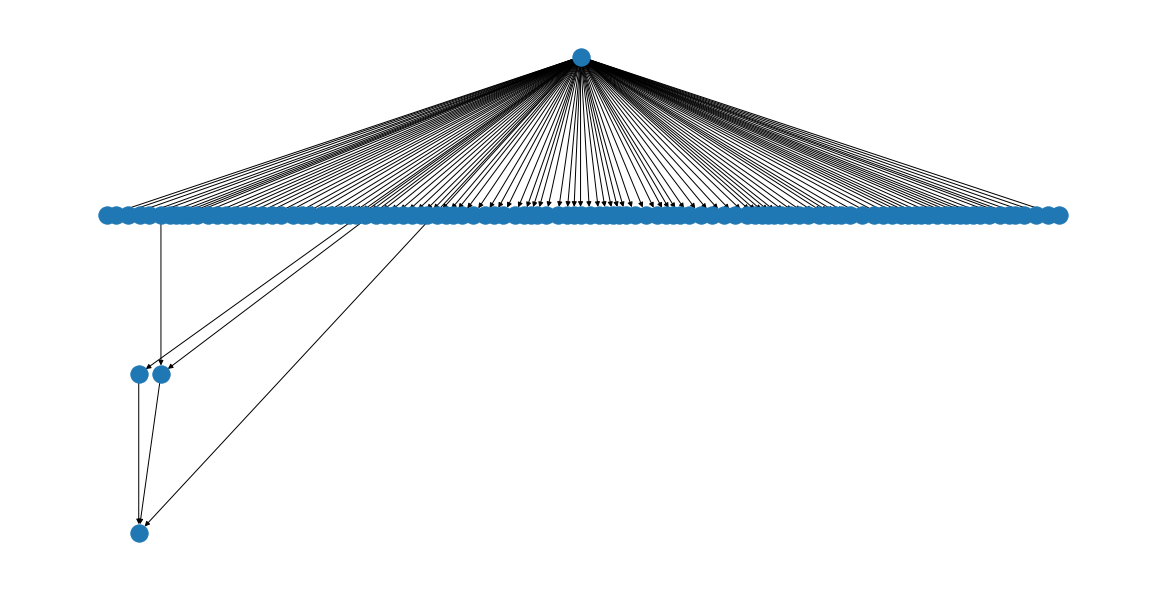

In [ ]:
plt.figure(figsize=(16,8))
pos = graphviz_layout(G, prog="dot")

nx.draw(G,pos,with_labels=False)

In [ ]:
#visualisation working step
A = nx.nx_agraph.to_agraph(G)   #convert to a graphviz graph
A.layout(prog='dot')            #neato layout
A.draw('graph.png',args='-Gnodesep=0.02 -Gfont_size=1', prog='dot') #nodesep = node seperation (imp param)

# Testing (without classes and objects) 

In [ ]:
import random, tweepy
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import networkx as nx 

consumer_key = 'xxxxxxx'
consumer_secret = 'xxxxxxx'
access_token_key = 'xxxxxxx-xxxxxxx'
access_token_secret = 'xxxxxxx'
bearer_token = 'xxxxxxxxxxxxxx'
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token_key, access_token_secret)
api = tweepy.API(auth, wait_on_rate_limit=True)
client = tweepy.Client(bearer_token,consumer_key, consumer_secret,access_token_key, access_token_secret, wait_on_rate_limit=True)

In [ ]:
help(client)

In [ ]:
import datetime 
import news_crawl
# first we collect news from news url
news_url = "https://www.usnews.com/news/politics/articles/2022-09-23/pink-wave-poised-to-upend-republican-midterm-prospects"
newsCollector = news_crawl.NewsContentCollector([news_url])
news_data=newsCollector.collect_data()

# search twitter timeline last 7-days mentioning the news url
data = api.search_tweets(q=news_url,count=1000)


  0%|          | 0/1 [00:02<?, ?it/s]


In [ ]:
graphs = []
g = Graph()

for i in data:
    G_news,nodes = g.get_graph_of_tweet(i.id)
    graphs.append(G_news)
